In [1]:
""" Cualquier librería adicional que necesiteis durante el ejercicio, importadlo en esta sección """

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math

sns.set_style('darkgrid')
np.set_printoptions(precision=2)
# warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PowerTransformer
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

from sklearn.model_selection import KFold, ShuffleSplit, LeaveOneOut, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Ejercicio 1

Este ejercicio pretende poner en práctica la habilidad para crear modelos en __sklearn__ mediante el uso de transformadores _ad hoc_.

El estudiante tendrá que repasar los comandos realizados en clase y lidiar con posibles errores durante el desarrollo. 

Para facilitar y agilizar el desarrollo, el estudiante tendrá que rellenar los huecos marcados como '_# codigo-alumno_'. No obstante, si además el estudiante necesita ejecutar código adicional, siempre podrá utilizar cualquier celda adicional. 

El estudiante tendrá siempre que introducir una semilla (seed) que generará acorde a su fecha de nacimiento (sin ser intrusivos en edad).

Finalmente, la entrega será un fichero .ipynb cambiando nombre y apellido al fichero.

In [2]:
""" El estudiante tendrá que utilizar la semilla proporcionada para todos los procesos aleatorios """
seed = 22 + 13 * 2

### Data cleansing

In [3]:
""" Leed el fichero con pandas y almacenarlo en una variable llamada data """

data = pd.read_csv('./data/titanic-2.csv')

In [4]:
""" Cread una variable adicional, llamada hasCabin, 
    que tome valor 0 si la columna Cabin es nula, y 1 si no lo es """

data['hasCabin'] = np.where(data['Cabin'].isnull(), 0, 1)

In [5]:
"""Eliminad las columnas PassengerId, Cabin, Ticket y Name de data (comando drop) """

data = data.drop(columns=['PassengerId', 'Cabin', 'Ticket','Name'])

In [6]:
""" Modificad las variables Title, Parch y SibSp, donde Title tome los valores Mr, Mrs, Miss y Otros. 
    Y Parch y SibSp toman los valores 0, 1 o 2 (donde 2 incluye 2 o más) """

data['SibSp'] = np.where(data['Parch']>=2, 2, data['Parch'])
data['Parch'] = np.where(data['SibSp']>=2, 2, data['SibSp'])
data['Title'] = np.where((data['Title']!='Mr')&(data['Title']!='Mrs')&(data['Title']!='Miss'), 'Otros', data['Title'])

In [7]:
""" Eliminad los dos registros cuyo valor Embarked es nulo 
    (se recomienda comprobar que se hayan eliminado correctamente) """

data.drop(data[data['Embarked'].isnull()].index, inplace = True)
data.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      0
Title         0
hasCabin      0
dtype: int64

In [8]:
""" Eliminad registros duplicados en caso de que los haya """
data=data.drop_duplicates()
data.duplicated().sum()

0

### Feature engineering

In [9]:
"""
Realizar un ColumnTransformer que lleve:
- Un KNN Imputer para 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'
- Un PowerTransformer yeo-johnson para 'Fare'
- Un OneHotEncoder para las variables 'Sex', 'Parch', 'Embarked' y 'Title'
"""
col_transformer = ColumnTransformer([
        ("imputer", KNNImputer(n_neighbors=5), ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']),
        ("transformer", PowerTransformer(method='yeo-johnson'), ['Fare']),
        ("encoder1", OneHotEncoder(), ['Sex', 'Parch', 'Embarked', 'Title'])
    ]
)

ctransformed = col_transformer.fit_transform(data)
ctransformed

array([[ 3. , 22. ,  0. , ...,  1. ,  0. ,  0. ],
       [ 1. , 38. ,  0. , ...,  0. ,  1. ,  0. ],
       [ 3. , 26. ,  0. , ...,  0. ,  0. ,  0. ],
       ...,
       [ 3. , 26.8,  2. , ...,  0. ,  0. ,  0. ],
       [ 1. , 26. ,  0. , ...,  1. ,  0. ,  0. ],
       [ 3. , 32. ,  0. , ...,  1. ,  0. ,  0. ]])

### Model Selection

In [10]:
""" Realizaremos un análisis de los siguientes modelos con las siguentes features """

models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier(random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('RFC', RandomForestClassifier(random_state=seed)))
models.append(('SVM', SVC()))

X = data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title', 'hasCabin']]
y = data['Survived']

In [11]:
""" Para plotear los resultados utilizaremos la siguiente función """

def boxplots_algorithms(results, names):
    
    plt.figure(figsize=(8,8))
    plt.boxplot(results)
    plt.xticks(range(1,len(names)+1), names)
    plt.show()

LR: 0.796657 (0.036524)
LDA: 0.790263 (0.042970)
KNN: 0.767267 (0.046063)
DTC: 0.739176 (0.045965)
NB: 0.754398 (0.039216)
RFC: 0.757043 (0.029092)
SVM: 0.799156 (0.047164)


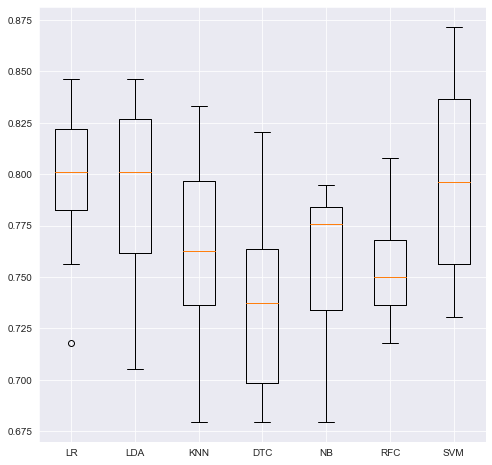

In [12]:
""" Realizad un bucle que calcule, para cada modelo,
    - Un pipeline que realice:
        1. El ColumnTransformer diseñado anteriormente
        2. Un RobustScaler a continuación y, finalmente, 
        3. Evalue cada modelo 
    - Una validación cruzada:
        1. Tipo KFolds, con 10 splits 
        2. Aleatorio con semilla y,
        3. scoring='accuracy'
     Usaremos la función boxplots_algorithms para plotear los resultados """

results = []
names = []

for name, model in models:
    
    scaler = RobustScaler()
    pipeline = make_pipeline(col_transformer, scaler, model)
    
    cv_technique = KFold(n_splits=10, shuffle=True, random_state=seed) 
    cv_results = cross_val_score(pipeline, X, y, cv=cv_technique, scoring='accuracy')
    
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
    results.append(cv_results)
    names.append(name)
    
boxplots_algorithms(results, names)

LR: 0.791577 (0.038796)
LDA: 0.786482 (0.041145)
KNN: 0.764654 (0.044857)
DTC: 0.707141 (0.048561)
NB: 0.753165 (0.036471)
RFC: 0.758358 (0.052397)
SVM: 0.795391 (0.050289)


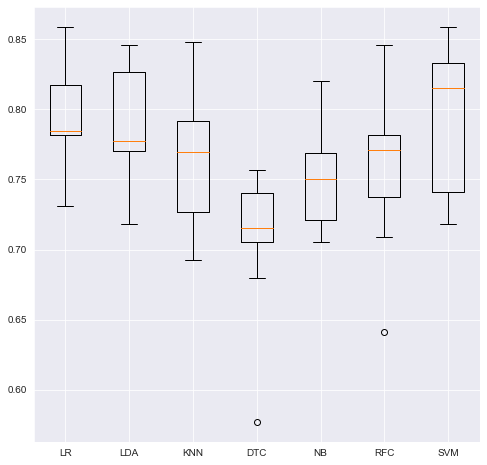

In [13]:
""" Realizad el mismo estudio de selección de variables, pero con StratifiedKFolds """

results = []
names = []

for name, model in models:
    
    scaler = RobustScaler()
    pipeline = make_pipeline(col_transformer, scaler, model)
    
    cv_technique = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed) 
    cv_results = cross_val_score(pipeline, X, y, cv=cv_technique, scoring='accuracy')
    
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
    results.append(cv_results)
    names.append(name)
    
boxplots_algorithms(results, names)

### Model Tuning

In [14]:
""" Realizad un Tuneado del RandomForestClassifier para estimar cuál es la mejor configuración paramétrica
    Y comprobarlo con GridSearchCV """

param_grid = {
    'model__n_estimators': [10, 20],
    'model__max_features': ['auto', 'sqrt', 'log2'],
    'model__max_depth' : [4,5,6,7,8],
    'model__criterion' :['gini', 'entropy']
}

model = RandomForestClassifier(random_state=seed)
    
pipeline = Pipeline([('transformacion_columna', col_transformer),
                    ('robust_scaler', scaler),
                    ('model', model)])
    
cv_technique = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    
grid_model = GridSearchCV(pipeline, param_grid=param_grid, cv=cv_technique)
    
grid_model.fit(X, y)
    
print(grid_model.best_score_)
print(grid_model.best_estimator_)

0.7980038948393379
Pipeline(steps=[('transformacion_columna',
                 ColumnTransformer(transformers=[('imputer', KNNImputer(),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch', 'Fare']),
                                                 ('transformer',
                                                  PowerTransformer(),
                                                  ['Fare']),
                                                 ('encoder1', OneHotEncoder(),
                                                  ['Sex', 'Parch', 'Embarked',
                                                   'Title'])])),
                ('robust_scaler', RobustScaler()),
                ('model',
                 RandomForestClassifier(max_depth=8, n_estimators=20,
                                        random_state=48))])
